# Business Understanding

## Background
My company is looking to get into movie creation using their newly created movie studio. 

## Business Goals
The primary focus of this data science project is to analyze and assess features that contribute to a movie's return on investment in order to make an informed decision regarding what features of movie creation my company should invest in.

## Business Success Criteria
The success of this project will be measured by providing three well-supported recommendations on the most cost efficient movie features (actors, directots, genre, marketing cost, movie rating (G, PG, PG-13, etc.)) to invest in. For this project, the most "cost efficient" features are measured by their return on investment which is defined as 100% times the total revenue divided by the initial investment of the film.

# Data Understanding

Data on movies is collected by a variety of different sources. For this project, I used data from the following sources:
- Box Office Mojo's "Movie Gross" dataset
    - This dataset includes 5 features and 3387 observations. Each entry in the dataset represents a different movie title. Additional information is included about each entry, such as the production studio, the domestic gross box office, the foreign gross box office, and the release year.
    
    
- Rotten Tomatoes "Movie Info" dataset
    - This dataset includes 12 features and 1560 observations/entries where each entry in the dataset represents a different movie. Even though the movie title is not included, each entry has an associated unique ID. Additional information is included about each entry, such as a synopsis, the movie rating, genre(s), director, writer, and runtime.
    
    
- Rotten Tomatoes "Movie Reviews" dataset
    - This dataset includes 8 features and 54432 observations/entries, where each entry in the dataset represents a different review left by a movie critic. Each entry contains an ID which refers to the movie the review is about. In addition to the review, other information for each entry includes a rating (out of 5), the critic's name, the publisher, and the date the review was left. 


- The Movie DB's "Movies" dataset
    - This dataset includes 10 features and 26517 observations. Each entry in the dataset represents a different movie. For each entry information is included about the movie's genre, original language, popularity score, and number of votes. 
    
    
- The Numbers' "movie_budgets" dataset
    - This dataset includes 6 features and 5782 observations. Each entry in the dataset represents a different movie. For each entry, information is included about the movie's release data, production budget, domestic gross box office, and worldwide gross box office.
    
    
- IMDB's film database
    - This database includes 8 tables. Its entity-related diagram (ERD) is shown below.  

## Data Preparation

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [12]:
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [13]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [14]:
# defining columns to format

budget_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

In [15]:
# formatting budget columns by removing the $

for col in budget_cols:
     budgets[col] = budgets[col].str.replace('$', '')
        
        
# formatting budget columns by removing commas

for col in budget_cols:
     budgets[col] = budgets[col].str.replace(',', '')

In [16]:
# changing dtype of budget and gross columns to int

for col in budget_cols:
     budgets[col] = budgets[col].astype(float)

In [17]:
#converting dollar amounts to amounts that are easier to read

for col in budget_cols:
    budgets[col] = round(budgets[col]/1000000, 1)

In [18]:
# renaming columns to include dollar sign
budgets.rename(columns={'production_budget': 'production_budget (millions of $)', 'domestic_gross': 'domestic_gross (millions of $)', 'worldwide_gross' : 'worldwide_gross (millions of $)'}, inplace=True)


In [19]:
budgets.head()

,id,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $)
0,1,"Dec 18, 2009",Avatar,425.0,760.5,2776.3
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.1,1045.7
2,3,"Jun 7, 2019",Dark Phoenix,350.0,42.8,149.8
3,4,"May 1, 2015",Avengers: Age of Ultron,330.6,459.0,1403.0
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317.0,620.2,1316.7


In [20]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 5782 non-null   int64  
 1   release_date                       5782 non-null   object 
 2   movie                              5782 non-null   object 
 3   production_budget (millions of $)  5782 non-null   float64
 4   domestic_gross (millions of $)     5782 non-null   float64
 5   worldwide_gross (millions of $)    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


In [21]:
# calculating the return on investment for each film and creating a column to hold this information

budgets['roi (%)'] = round(((budgets['domestic_gross (millions of $)'] + budgets['worldwide_gross (millions of $)'] - budgets['production_budget (millions of $)'])/ 
                budgets['production_budget (millions of $)']) * 100, 2)

In [22]:
budgets['id'].value_counts()

4      58
53     58
61     58
65     58
69     58
       ..
85     57
100    57
96     57
92     57
97     57
Name: id, Length: 100, dtype: int64

In [23]:
# inspecting all entries with id of '4'
budgets[budgets['id'] == 4].head(15)

,id,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
3,4,"May 1, 2015",Avengers: Age of Ultron,330.6,459.0,1403.0,463.22
103,4,"Mar 27, 2009",Monsters vs. Aliens,175.0,198.4,381.7,231.49
203,4,"Jul 15, 2016",Ghostbusters,144.0,128.4,229.0,148.19
303,4,"May 19, 1999",Star Wars Ep. I: The Phantom Menace,115.0,474.5,1027.0,1205.65
403,4,"Dec 14, 2018",Mortal Engines,100.0,16.0,85.3,1.30
503,4,"Sep 29, 2006",Open Season,85.0,85.1,191.9,225.88
603,4,"Dec 25, 1997",The Postman,80.0,17.7,20.8,-51.88
703,4,"Aug 8, 2003",S.W.A.T.,70.0,116.9,207.2,363.00
803,4,"Sep 14, 2012",Resident Evil: Retribution,65.0,42.3,240.6,335.23
903,4,"Jan 11, 2013",Gangster Squad,60.0,46.0,104.1,150.17


In [24]:
budgets.drop(['id'], axis=1, inplace=True)
budgets.head()

,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
0,"Dec 18, 2009",Avatar,425.0,760.5,2776.3,732.19
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.1,1045.7,213.40
2,"Jun 7, 2019",Dark Phoenix,350.0,42.8,149.8,-44.97
3,"May 1, 2015",Avengers: Age of Ultron,330.6,459.0,1403.0,463.22
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317.0,620.2,1316.7,511.01


In [25]:
# checking for duplicate movie entries
budgets.movie.value_counts()

King Kong                   3
Halloween                   3
Home                        3
The Square                  2
Unforgettable               2
                           ..
Moonraker                   1
Dheepan                     1
The Hunt for Red October    1
Bang                        1
About a Boy                 1
Name: movie, Length: 5698, dtype: int64

In [26]:
# checking for any movie titles with more than one entry to see if it is a duplicate entry or a remake

multiple_values = budgets.movie.value_counts()
budgets[budgets.movie.isin(multiple_values.index[multiple_values.gt(1)])]

,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
26,"May 4, 2012",The Avengers,225.0,623.3,1517.9,851.64
38,"May 14, 2010",Robin Hood,210.0,105.5,322.5,103.81
39,"Dec 14, 2005",King Kong,207.0,218.1,550.5,271.30
50,"Mar 5, 2010",Alice in Wonderland,200.0,334.2,1025.5,579.85
64,"Jun 9, 2017",The Mummy,195.0,80.1,410.0,151.33
...,...,...,...,...,...,...
5668,"Nov 16, 1942",Cat People,0.1,4.0,8.0,11900.00
5676,"Oct 1, 1968",Night of the Living Dead,0.1,12.1,30.1,42100.00
5677,"Feb 8, 1915",The Birth of a Nation,0.1,10.0,11.0,20900.00
5699,"Aug 30, 1972",The Last House on the Left,0.1,3.1,3.1,6100.00


In [27]:
budgets.describe()

,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
count,5782.000000,5782.000000,5782.000000,5743.00
mean,31.587236,41.872605,91.486942,inf
std,41.812440,68.240878,174.719871,NaN
min,0.000000,0.000000,0.000000,-100.00
25%,5.000000,1.400000,4.100000,-17.89
50%,17.000000,17.200000,28.000000,170.00
75%,40.000000,52.375000,97.675000,492.00
max,425.000000,936.700000,2776.300000,inf


In [28]:
#setting up connection to database

conn = sqlite3.connect('im.db')
cur = conn.cursor()

In [29]:
# creating a dataframe with a list of all tables in the database

db_tables = pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type = 'table';

""", conn)

db_tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [30]:
# prints the name of each table in the database with the count of rows in each table

table_names = list(db_tables['name'])

tables = {key: None for key in table_names}

for table_name in tables.keys():
    query = f"SELECT COUNT(*) AS num_rows FROM {table_name}"
    tables[table_name] = conn.execute(query).fetchone()[0]
    
tables

{'movie_basics': 146144,
 'directors': 291174,
 'known_for': 1638260,
 'movie_akas': 331703,
 'movie_ratings': 73856,
 'persons': 606648,
 'principals': 1028186,
 'writers': 255873}

In [31]:
movie_basics = pd.read_sql("""

SELECT * 
FROM movie_basics

""", conn)

movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [32]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [33]:
# comparing movies whose primary title does not match its original title

movie_basics[movie_basics['primary_title'] != movie_basics['original_title']][['primary_title', 'original_title']]

,primary_title,original_title
1,One Day Before the Rainy Season,Ashad Ka Ek Din
4,The Wandering Soap Opera,La Telenovela Errante
11,So Much for Justice!,Oda az igazság
13,Children of the Green Dragon,A zöld sárkány gyermekei
15,The Tragedy of Man,Az ember tragédiája
...,...,...
146026,Journey of the Sky Goddess,Kibaiyanse! Watashi
146028,Lupin the Third: Fujiko Mine's Lie,Lupin the IIIrd: Mine Fujiko no Uso
146037,Big Three Dragons,Da San Yuan
146121,A Cherry Tale,Kirsebæreventyret


In [34]:
movie_basics[movie_basics['primary_title'] != movie_basics['original_title']]['original_title'].value_counts()

La traversée                     3
Mi cheng                         2
L'amour                          2
Kokoro ga sakebitagatterunda.    2
Ming zhong zhu ding              2
                                ..
Gegege no nyôbô                  1
Shekaf                           1
Lian ai kong huang zheng         1
Jeong-ug-no-lae-jalang           1
Andrey Zvyagintsev. Rezhisser    1
Name: original_title, Length: 14452, dtype: int64

In [35]:
# removing original title column
movie_basics.drop('original_title', axis=1, inplace=True)

In [36]:
# get a count for the number of each genre

movie_basics['genres'].str.split(',').explode().value_counts()

Documentary    51640
Drama          49883
Comedy         25312
Thriller       11883
Horror         10805
Action         10335
Romance         9372
Biography       8722
Crime           6753
Adventure       6465
Family          6227
History         6225
Mystery         4659
Music           4314
Fantasy         3516
Sci-Fi          3365
Animation       2799
Sport           2234
News            1551
Musical         1430
War             1405
Western          467
Reality-TV        98
Talk-Show         50
Adult             25
Short             11
Game-Show          4
Name: genres, dtype: int64

In [37]:
# formatting genres column to create a list containing each genre for the film
movie_basics["genres_list"] = movie_basics["genres"].str.split(",")

In [38]:
# display number of nan values for each feature
movie_basics.isna().sum()

movie_id               0
primary_title          0
start_year             0
runtime_minutes    31739
genres              5408
genres_list         5408
dtype: int64

In [39]:
# return the number of rows with nans in both genre and runtime
len(movie_basics.loc[movie_basics['genres'].isnull() & movie_basics['runtime_minutes'].isnull()])

3236

In [40]:
# removing rows from movie_basics with null genre and runtime
movie_basics_clean = movie_basics.drop(movie_basics.loc[movie_basics['genres'].isnull() & movie_basics['runtime_minutes'].isnull()].index)
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   start_year       146144 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
 5   genres_list      140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [41]:
# confirming that correct number of rows were filtered out
len(movie_basics) - len(movie_basics_clean)

3236

In [42]:
movie_basics_clean.isna().sum()

movie_id               0
primary_title          0
start_year             0
runtime_minutes    28503
genres              2172
genres_list         2172
dtype: int64

In [43]:
# checking to see the runtimes of movies
movie_basics_clean.runtime_minutes.value_counts().sort_values(ascending = False)

90.0      7131
80.0      3526
85.0      2915
100.0     2662
95.0      2549
          ... 
406.0        1
1184.0       1
263.0        1
363.0        1
540.0        1
Name: runtime_minutes, Length: 367, dtype: int64

In [44]:
principals = pd.read_sql("""

SELECT *
FROM principals
""", conn)

principals.head()

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


In [45]:
principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


In [46]:
principals['category'].value_counts()

actor                  256718
director               146393
actress                146208
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65424
editor                  55512
production_designer      9373
archive_footage          3307
archive_sound              16
Name: category, dtype: int64

In [47]:
principals['job'].value_counts()

producer                                                             108168
screenplay                                                             8172
director of photography                                                6517
writer                                                                 6479
co-director                                                            5796
                                                                      ...  
novel "Ciencias Morales                                                   1
novel "El juego de los niños                                              1
book "Imperial Life in the Emerald City: Inside Iraq's Green Zone         1
writers room                                                              1
based upon the novel "The Scorch Trials" by                               1
Name: job, Length: 2965, dtype: int64

In [48]:
principals['characters'].value_counts()

["Himself"]                         43584
["Herself"]                         16127
["Narrator"]                         2218
["Alex"]                              656
["David"]                             620
                                    ...  
["Co pilot"]                            1
["Belen Miller"]                        1
["Captain 'Banks' Bancroft, MD"]        1
["Yeong-jo"]                            1
["Mother Najma"]                        1
Name: characters, Length: 174762, dtype: int64

In [49]:
# Dropping job and character columns 

principals.drop(['job', 'characters', 'ordering'], axis=1, inplace=True)

In [50]:
persons = pd.read_sql("""

SELECT *
FROM persons
""", conn)

persons.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [51]:
persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


In [52]:
# get a count for the number of each profession
persons['primary_profession'].str.split(',').explode().value_counts()

actor                        177838
producer                     150214
writer                       141504
director                     129808
actress                       95066
cinematographer               61984
editor                        55234
composer                      48823
camera_department             39466
miscellaneous                 38661
soundtrack                    20748
music_department              18568
assistant_director            15916
sound_department              15280
editorial_department          14565
production_manager             9768
art_department                 8913
production_designer            7592
visual_effects                 6188
art_director                   4623
stunts                         4309
casting_department             2802
executive                      2657
make_up_department             2613
animation_department           2459
casting_director               2397
location_management            2253
costume_department          

In [53]:
persons.drop(['birth_year', 'death_year', 'primary_profession'], axis=1, inplace=True)

In [54]:
data = [movie_basics_clean, principals, persons]
def info(dataframes):
    for df in dataframes:
        print("--------")
        print()
        print(df.info())

In [55]:
info(data)

--------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142908 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         142908 non-null  object 
 1   primary_title    142908 non-null  object 
 2   start_year       142908 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
 5   genres_list      140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.6+ MB
None
--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   movie_id   1028186 non-null  object
 1   person_id  1028186 non-null  object
 2   category   1028186 non-null  object
dtypes: object(3)
memory usage: 23.5+ MB
None
--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6066

In [56]:
# joining principals and persons dfs

film_people = pd.merge(persons, principals, how = 'inner', on = 'person_id')
film_people.head()

,person_id,primary_name,movie_id,category
0,nm0061671,Mary Ellen Bauder,tt2398241,producer
1,nm0061865,Joseph Bauer,tt0433397,composer
2,nm0061865,Joseph Bauer,tt1681372,composer
3,nm0061865,Joseph Bauer,tt2387710,composer
4,nm0061865,Joseph Bauer,tt2281215,composer


In [57]:
film_people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027912 entries, 0 to 1027911
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   person_id     1027912 non-null  object
 1   primary_name  1027912 non-null  object
 2   movie_id      1027912 non-null  object
 3   category      1027912 non-null  object
dtypes: object(4)
memory usage: 39.2+ MB


In [58]:
film_people.category.value_counts()

actor                  256561
director               146393
actress                146124
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65392
editor                  55512
production_designer      9373
archive_footage          3306
archive_sound              16
Name: category, dtype: int64

In [59]:
film_people.person_id.value_counts()

nm1930572     378
nm0000636     160
nm0000616     148
nm0103977     126
nm4394575     103
             ... 
nm10177262      1
nm7254083       1
nm1042859       1
nm8888229       1
nm1779571       1
Name: person_id, Length: 604290, dtype: int64

In [60]:
film_people[film_people['person_id'] == 'nm4394575']

,person_id,primary_name,movie_id,category
415221,nm4394575,Sen Arima,tt2414424,editor
415222,nm4394575,Sen Arima,tt2418914,editor
415223,nm4394575,Sen Arima,tt3445098,editor
415224,nm4394575,Sen Arima,tt2419230,editor
415225,nm4394575,Sen Arima,tt2410964,editor
...,...,...,...,...
415319,nm4394575,Sen Arima,tt9525226,editor
415320,nm4394575,Sen Arima,tt6370780,editor
415321,nm4394575,Sen Arima,tt6374832,editor
415322,nm4394575,Sen Arima,tt7843050,editor


In [61]:
film_people.value_counts()

person_id  primary_name     movie_id   category
nm3296031  Brendan Maclean  tt2815358  actor       2
nm2442121  Ivy Yi-Han Chen  tt8942260  actress     2
nm4454963  Mike Kai Sui     tt6450032  actor       2
nm3206691  Hasan Majuni     tt2258513  actor       2
nm1289422  Barbara Bacci    tt3153648  actress     2
                                                  ..
nm4885985  Rémi Goulet      tt7610830  actor       1
                            tt4027334  actor       1
                            tt2224307  actor       1
nm4885974  Mónica Portillo  tt6207386  actress     1
nm0000002  Lauren Bacall    tt0858500  actress     1
Length: 1027877, dtype: int64

In [62]:
# removes duplicate rows that share the same movie_id and person_id

film_people_duplicates = film_people.duplicated(keep = False)
film_people[film_people_duplicates].value_counts()

person_id  primary_name            movie_id   category
nm9161308  Sameer Deshpande        tt5489544  actor       2
nm1289422  Barbara Bacci           tt3153648  actress     2
nm3296031  Brendan Maclean         tt2815358  actor       2
nm3206691  Hasan Majuni            tt2258513  actor       2
nm3187984  Abdellatif Chaouqi      tt3592504  actor       2
nm2442121  Ivy Yi-Han Chen         tt8942260  actress     2
nm2335900  Justin Malone           tt1995481  actor       2
nm1794850  David Chalmers          tt2073120  actor       2
nm1141719  Nobuyuki Kase           tt5098626  actor       2
nm3548929  Liuyuan Ding            tt5338100  actress     2
nm0857847  Thich Nhát Hanh         tt5268106  actor       2
nm0849468  Masashi Taniguchi       tt8108180  actor       2
nm0605583  Robert Morin            tt6664852  actor       2
nm0406809  Kunihiko Ida            tt5495582  actor       2
nm0244327  Dorra Zarrouk           tt6549064  actress     2
nm0172826  Luigi Cozzi             tt4537170 

In [63]:
film_people_no_dups = film_people.drop_duplicates()
film_people_no_dups.value_counts()

person_id  primary_name               movie_id    category
nm9993680  Christopher-Lawson Palmer  tt10427366  actor       1
nm1822501  Reece Rios                 tt1591509   actor       1
nm1822600  Anastas Tanovski           tt7610008   actor       1
nm1822582  Claude Stark               tt6046566   actor       1
nm1822570  Esham                      tt2006716   self        1
                                                             ..
nm4886005  Abi Alberto                tt2224159   director    1
nm4885998  Mott Green                 tt2224377   self        1
nm4885985  Rémi Goulet                tt7610830   actor       1
                                      tt4027334   actor       1
nm0000002  Lauren Bacall              tt0858500   actress     1
Length: 1027877, dtype: int64

In [64]:
film_people_no_dups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027877 entries, 0 to 1027911
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   person_id     1027877 non-null  object
 1   primary_name  1027877 non-null  object
 2   movie_id      1027877 non-null  object
 3   category      1027877 non-null  object
dtypes: object(4)
memory usage: 39.2+ MB


In [65]:
pd.merge(film_people_no_dups, movie_basics_clean, how = 'inner', on = 'movie_id')

,person_id,primary_name,movie_id,category,primary_title,start_year,runtime_minutes,genres,genres_list
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
1,nm0038432,Kelly Asbury,tt2398241,director,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
2,nm0449549,Jordan Kerner,tt2398241,producer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
3,nm0962596,Pamela Ribon,tt2398241,writer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
4,nm0678963,Peyo,tt2398241,writer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
...,...,...,...,...,...,...,...,...,...
1017259,nm9529323,Klaus Erik Okstad,tt7826456,director,Det Afghanske Marerittet,2011,54.0,Documentary,[Documentary]
1017260,nm9734471,Reza Aghaei,tt8207434,director,Glasses,2017,75.0,"Drama,Family","[Drama, Family]"
1017261,nm9743728,Efrain Sosa,tt8226498,director,Finding the Night of the Dead,2019,62.0,Documentary,[Documentary]
1017262,nm9909687,Bastien Larue,tt8561352,director,Les officiants,2016,52.0,Documentary,[Documentary]


In [66]:
# joining film_people_no_dups and movie_basics_clean

film_people_with_movies = pd.merge(film_people_no_dups, movie_basics_clean, how = 'inner', on = 'movie_id')

In [67]:
# Dropping job and character columns 

film_people_with_movies.drop('runtime_minutes', axis=1, inplace=True)

In [68]:
film_people_with_movies.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
1,nm0038432,Kelly Asbury,tt2398241,director,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
2,nm0449549,Jordan Kerner,tt2398241,producer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
3,nm0962596,Pamela Ribon,tt2398241,writer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
4,nm0678963,Peyo,tt2398241,writer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"


In [69]:
film_people_with_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017264 entries, 0 to 1017263
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   person_id      1017264 non-null  object
 1   primary_name   1017264 non-null  object
 2   movie_id       1017264 non-null  object
 3   category       1017264 non-null  object
 4   primary_title  1017264 non-null  object
 5   start_year     1017264 non-null  int64 
 6   genres         1006151 non-null  object
 7   genres_list    1006151 non-null  object
dtypes: int64(1), object(7)
memory usage: 69.8+ MB


In [70]:
# check to ensure there are no duplicate rows that share the same person_id and movie_id

#len(film_people_with_movies[film_people_with_movies.duplicated(keep = False)])

In [71]:
# removing any person with a frequency less than three 

#gets a count of the frequency of each person's name in the df
film_people_value_counts = film_people_with_movies.primary_name.value_counts() 

# selects the names that appear less than 3 times
remove_people = film_people_value_counts[film_people_value_counts < 3].index

# filters out rows that have a primary_name that is in remove_people
film_people_mult_movies = film_people_with_movies[~film_people_with_movies['primary_name'].isin(remove_people)]

In [72]:
film_people_mult_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448272 entries, 1 to 1017238
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   person_id      448272 non-null  object
 1   primary_name   448272 non-null  object
 2   movie_id       448272 non-null  object
 3   category       448272 non-null  object
 4   primary_title  448272 non-null  object
 5   start_year     448272 non-null  int64 
 6   genres         443912 non-null  object
 7   genres_list    443912 non-null  object
dtypes: int64(1), object(7)
memory usage: 30.8+ MB


In [73]:
# list of movies in the top 25% of roi
top_25_percent_roi = list(budgets[budgets['roi (%)'] > budgets['roi (%)'].quantile(.75)].sort_values(by = ['roi (%)'], ascending = False)['movie'])

In [74]:
# filtering movie_basics_clean to only include movies in the top 25% of roi

top_roi_movie_basics = movie_basics_clean[movie_basics_clean['primary_title'].isin(top_25_percent_roi)]
top_roi_movie_basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,genres_list
33,tt0293429,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy","[Action, Adventure, Fantasy]"
40,tt0326592,The Overnight,2010,88.0,None,None
60,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi","[Action, Adventure, Sci-Fi]"
97,tt0431021,The Possession,2012,92.0,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]"
104,tt0435761,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"


In [75]:
top_roi_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 33 to 145664
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         816 non-null    object 
 1   primary_title    816 non-null    object 
 2   start_year       816 non-null    int64  
 3   runtime_minutes  735 non-null    float64
 4   genres           809 non-null    object 
 5   genres_list      809 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 44.6+ KB


In [76]:
# creates df containing the people involved in the movies in the top 25% of roi
top_roi_film_people = film_people_mult_movies[film_people_mult_movies['primary_title'].isin(top_25_percent_roi)]
top_roi_film_people.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list
2255,nm0093589,Matt Bomer,tt2268016,actor,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]"
2256,nm0917059,Nick Wechsler,tt2268016,producer,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]"
2257,nm0542133,Joe Manganiello,tt2268016,actor,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]"
2258,nm0735226,Adam Rodriguez,tt2268016,actor,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]"
2259,nm0414423,Gregory Jacobs,tt2268016,director,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]"


In [77]:
# removing any person with a frequency less than three 

#gets a count of the frequency of each person's name in the df
top_people_value_counts = top_roi_film_people.primary_name.value_counts() 

# selects the names that appear less than 3 times
remove_ppl = top_people_value_counts[top_people_value_counts < 3].index

# filters out rows that have a primary_name that is in remove_people
top_roi_people = top_roi_film_people[~top_roi_film_people['primary_name'].isin(remove_ppl)]

In [78]:
top_roi_people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1014 entries, 2260 to 809981
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   person_id      1014 non-null   object
 1   primary_name   1014 non-null   object
 2   movie_id       1014 non-null   object
 3   category       1014 non-null   object
 4   primary_title  1014 non-null   object
 5   start_year     1014 non-null   int64 
 6   genres         1014 non-null   object
 7   genres_list    1014 non-null   object
dtypes: int64(1), object(7)
memory usage: 71.3+ KB


In [79]:
# joining top_roi_film_people and budgets

top_people_budgets = pd.merge(top_roi_people, budgets, how = 'inner', left_on = 'primary_title', right_on = 'movie')
top_people_budgets.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
0,nm0001752,Steven Soderbergh,tt2268016,cinematographer,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]","Jul 1, 2015",Magic Mike XXL,14.5,66.0,123.7,1208.28
1,nm1475594,Channing Tatum,tt2268016,actor,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]","Jul 1, 2015",Magic Mike XXL,14.5,66.0,123.7,1208.28
2,nm1749221,Nina Jacobson,tt1650043,producer,Diary of a Wimpy Kid: Rodrick Rules,2011,"Comedy,Family","[Comedy, Family]","Mar 25, 2011",Diary of a Wimpy Kid: Rodrick Rules,18.0,52.7,73.7,602.22
3,nm0331516,Ryan Gosling,tt1120985,actor,Blue Valentine,2010,"Drama,Romance","[Drama, Romance]","Dec 29, 2010",Blue Valentine,1.0,9.7,16.6,2530.00
4,nm0931329,Michelle Williams,tt1120985,actress,Blue Valentine,2010,"Drama,Romance","[Drama, Romance]","Dec 29, 2010",Blue Valentine,1.0,9.7,16.6,2530.00


In [80]:
top_people_budgets.person_id.value_counts()

nm0089658    34
nm0000881    11
nm0366389    11
nm1490123     9
nm1325419     8
             ..
nm1448916     3
nm0908094     2
nm0425053     2
nm1512937     2
nm2053216     1
Name: person_id, Length: 261, dtype: int64

In [81]:
top_people_budgets.primary_name.value_counts()

Jason Blum           34
Michael Bay          11
Kevin Hart           11
James Wan             9
Jennifer Lawrence     8
                     ..
Steven Schneider      3
Samuel L. Jackson     3
Michael Bacall        3
Carmen Ejogo          3
Meryl Streep          3
Name: primary_name, Length: 259, dtype: int64

In [85]:
top_people_budgets[top_people_budgets['person_id'] == 'nm1512937']

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
351,nm1512937,Paul Walker,tt3474788,writer,The Gift,2014,"Action,Drama,Thriller","[Action, Drama, Thriller]","Dec 19, 2000",The Gift,10.0,12.0,44.6,466.0
352,nm1512937,Paul Walker,tt3474788,writer,The Gift,2014,"Action,Drama,Thriller","[Action, Drama, Thriller]","Aug 7, 2015",The Gift,5.0,43.8,59.0,1956.0


In [86]:
top_people_budgets[top_people_budgets['primary_name'] == 'Paul Walker']

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
197,nm0908094,Paul Walker,tt1596343,actor,Fast Five,2011,"Action,Crime,Thriller","[Action, Crime, Thriller]","Apr 29, 2011",Fast Five,125.0,210.0,630.2,572.16
211,nm0908094,Paul Walker,tt2820852,actor,Furious 7,2015,"Action,Crime,Thriller","[Action, Crime, Thriller]","Apr 3, 2015",Furious 7,190.0,353.0,1518.7,885.11
351,nm1512937,Paul Walker,tt3474788,writer,The Gift,2014,"Action,Drama,Thriller","[Action, Drama, Thriller]","Dec 19, 2000",The Gift,10.0,12.0,44.6,466.00
352,nm1512937,Paul Walker,tt3474788,writer,The Gift,2014,"Action,Drama,Thriller","[Action, Drama, Thriller]","Aug 7, 2015",The Gift,5.0,43.8,59.0,1956.00


# Exploratory Data Analysis

In [ ]:
# getting summary statistics for the int cols of the budgets table
budgets.describe()

The output shows summary statistics for the columns with float values, where 50% is the median of the data. Comparing the mean and median for each column provides information about the shape of each column of data. For example, the median return on investment (roi) is 165.95% while the mean is 678.94% which means that there are outliers in this data which is pulling the mean up.

In [ ]:
# creating histograms to visualize distributions for each column of budgets
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 6))
budgets.hist(ax = ax, bins = 15);

The histograms above confirm the information from the table earlier. Each histogram appears to be right skewed, which indicates that the mean will be greater than the median.

In [ ]:
# plotting roi histogram without outliers
mean = budgets['roi (%)'].mean()
stan_dev = budgets['roi (%)'].std()

outliers_threshold = 3 * stan_dev

hist_no_outliers = budgets[(budgets['roi (%)'] > (mean - outliers_threshold)) & (budgets['roi (%)'] < (mean + outliers_threshold))]

hist_no_outliers['roi (%)'].hist(bins=30, color='goldenrod', edgecolor='black');

In [ ]:
sns.boxplot(budgets['production_budget (millions of $)']);

The boxplot above shows...

In [ ]:
# getting summary statistics for top_roi_movie_basics
top_roi_movie_basics.describe()

In [ ]:
# plotting runtime histogram without outliers
runtime_mean = movie_basics_clean['runtime_minutes'].mean()
runtime_stan_dev = movie_basics_clean['runtime_minutes'].std()

outliers_threshold = 1 * runtime_stan_dev

runtime_hist_no_outliers = movie_basics_clean[(movie_basics_clean['runtime_minutes'] > (runtime_mean - outliers_threshold)) & (movie_basics_clean['runtime_minutes'] < (runtime_mean + outliers_threshold))]

runtime_hist_no_outliers['runtime_minutes'].hist(bins=30, color='goldenrod', edgecolor='black');

In [ ]:
sns.histplot(runtime_hist_no_outliers['runtime_minutes'], bins = 30);

In [ ]:
# getting the top genres for the movies in the top 25% roi

top_genres_count = top_roi_movie_basics['genres'].str.split(",").explode().value_counts()
top_genres = list(top_genres_count.index)
top_genres

In [ ]:
# horizontal bar plot showing the counts of genres for highest roi movies
sns.barplot(y = top_genres, x = top_genres_count);


In [ ]:
# creating a list of the top 2 genres of movies in top 25% roi
top2_genres = list(round(top_roi_movie_basics['genres'].explode().value_counts(normalize = True), 3)[:2].index)

In [ ]:
sns.histplot(top_roi_movie_basics['runtime_minutes']);

In [ ]:
# boxplot for the runtime of the movies in top 25% of roi
sns.boxplot(top_roi_movie_basics['runtime_minutes'], showfliers = False)
plt.axvline(x = 86, color = 'red', label = 'axvline - full height', linestyle = '--')
plt.axvline(x = 114, color = 'red', label = 'axvline - full height', linestyle = '--');
#plt.x_ticks;

In [ ]:
top_roi_people.category.value_counts()

In [113]:
avgtop_people_budgets.groupby(['person_id', 'primary_name']).mean()[['worldwide_gross (millions of $)']].sort_values('worldwide_gross (millions of $)', ascending = False)


,,worldwide_gross (millions of $)
person_id,primary_name,
nm0456158,Jack Kirby,1437.975000
nm0498278,Stan Lee,1216.380000
nm0000375,Robert Downey Jr.,1141.716667
nm0908094,Paul Walker,1074.450000
nm0695435,Chris Pratt,1045.825000
...,...,...
nm1458741,John Guleserian,31.400000
nm2271939,Brian Kavanaugh-Jones,26.850000
nm0489059,Nathan Larson,19.833333


In [119]:
# creates df with top actors and actresses
top_actors = top_people_budgets[(top_people_budgets['category'] == 'actor') | (top_people_budgets['category'] == 'actress')]

top_actors_sum_gross = top_actors.groupby(['primary_name']).sum()[['worldwide_gross (millions of $)', 'roi (%)']].sort_values('worldwide_gross (millions of $)', ascending = False).head()
top_actors_mean_gross = top_actors.groupby(['primary_name']).mean()[['worldwide_gross (millions of $)', 'roi (%)']].sort_values('worldwide_gross (millions of $)', ascending = False).head(20)

list(top_actors_sum_gross.index & top_actors_mean_gross.index)[:5]
#count_of_top_actors = top_actors.primary_name.value_counts().head(20)
#top_15_actors = count_of_top_actors.head(15)
#top_15_actors

['Robert Downey Jr.',
 'Chris Evans',
 'Chris Pratt',
 'Scarlett Johansson',
 'Josh Gad']

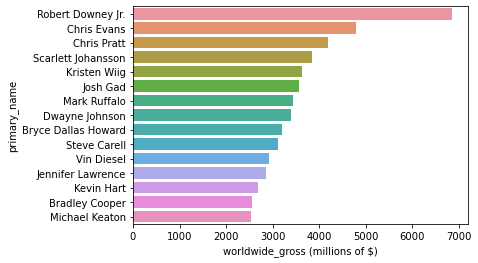

In [110]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

sns.barplot(
    y = top_15_actors.index, 
    x = top_15_actors['worldwide_gross (millions of $)'], ax = ax[0])

sns.barplot(
    y = top_15_actors.index, 
    x = top_15_actors['worldwide_gross (millions of $)'], ax = ax[0]);

In [ ]:
# returns a df for all comedies and dramas within the top_roi_people

top_roi_people[top_roi_people['genres'].str.contains('|'.join(top2_genres))]

In [ ]:
# returns a df with the top comedy and drama producers
top_com_dram_producers = (top_roi_people['category'] == 'producer') & (top_roi_people['genres'].str.contains('|'.join(top2_genres)))
val_counts_top_drom_producers = top_roi_people[top_com_dram_producers].primary_name.value_counts().head(15)

In [ ]:
# bar plot of top producers top roi movies
sns.barplot(
    y = val_counts_top_drom_producers.index, 
    x = val_counts_top_drom_producers);

In [ ]:
# returns a df with the top comedy and drama directors
top_com_dram_directors = (top_roi_people['category'] == 'director') & (top_roi_people['genres'].str.contains('|'.join(top2_genres)))
val_counts_top_drom_directors = top_roi_people[top_com_dram_directors].primary_name.value_counts().head(15)

In [ ]:
# bar plot of top producers top roi movies
sns.barplot(
    y = val_counts_top_drom_directors.index, 
    x = val_counts_top_drom_directors);

In [ ]:
# returns a df with the top comedy and drama directors
top_com_dram_writers = (top_roi_people['category'] == 'writer') & (top_roi_people['genres'].str.contains('|'.join(top2_genres)))
val_counts_top_drom_writers = top_roi_people[top_com_dram_writers].primary_name.value_counts().head(15)


In [ ]:
# bar plot of top writers of top roi movies
sns.barplot(
    y = val_counts_top_drom_writers.index, 
    x = val_counts_top_drom_writers);

In [ ]:
# returns a df with the top comedy and drama writers

top_com_dram_writers = (top_roi_people['category'] == 'writer') & (top_roi_people['genres'].str.contains('|'.join(top2_genres)))

top_writers = top_roi_people[top_com_dram_writers].primary_name.value_counts()

remove_writers = top_writers[top_writers < 3].index

top4_com_dram_writers = top_roi_people[top_roi_people['primary_name'].isin(remove_writers)]
top4_com_dram_writers

In [ ]:
#gets a count of the frequency of each person's name in the df
film_people_value_counts = film_people_with_movies.primary_name.value_counts() 

# selects the names that appear less than 3 times
remove_people = film_people_value_counts[film_people_value_counts < 3].index

# filters out rows that have a primary_name that is in remove_people
film_people_mult_movies = film_people_with_movies[~film_people_with_movies['primary_name'].isin(remove_people)]

# Conclusion
 
## Limitations

## Recommendations

This analysis leads to three recommendations for movie creation:

1. Create a drama or comedy movie by hiring one of the following writers: 
-  
2. Create a movie with a runtime between 86 and 114 minutes

3. Cast an actor from the following list to star in the movie:  


## Next Steps

With these recommendations in mind, I am interested the following next steps:
- gathering more budget data on a larger amount of movies
- having addition time to perform analysis on the amount of gross USD the recommended writers, actors, and directors each brought in
- performing regression analysis to determine which factors are most strongly correlation with a movie's return on investment

# Resources

- got error when trying to read in reviews.tsv dataset: "UnicodeDecodeError: 'utf8' codec can't decode byte 0xa5 in position 0: invalid start byte". This resource helped: https://stackoverflow.com/questions/22216076/unicodedecodeerror-utf8-codec-cant-decode-byte-0xa5-in-position-0-invalid-s

- Had trouble reading zipped data with pandas. This helped me with reading in the csv and tsv data: https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe

- for joining datasets: https://stackoverflow.com/questions/53645882/pandas-merging-101

- the movie_info dataset had the word 'minutes' in each entry for runtime. Just wanted the numbers. this was helpful:
https://saturncloud.io/blog/how-to-remove-characters-from-a-pandas-column-a-data-scientists-guide/

- merging on more than one condition: https://stackoverflow.com/questions/53549492/joining-two-pandas-dataframes-based-on-multiple-conditions

- dropping nulls in certain columns: https://saturncloud.io/blog/how-to-delete-rows-with-null-values-in-a-specific-column-in-pandas-dataframe/#:~:text=Deleting%20rows%20with%20null%20values%20in%20a%20specific%20column%20can,values%20in%20the%20specified%20column.&text=df%20is%20the%20Pandas%20DataFrame%20that%20you%20want%20to%20modify.

- for subsetting dataframe to only show entries with value count more than one https://stackoverflow.com/questions/48628417/how-to-select-rows-in-pandas-dataframe-where-value-appears-more-than-once

- Finding rows with matching entries: https://stackoverflow.com/questions/22485375/efficiently-select-rows-that-match-one-of-several-values-in-pandas-dataframe

For trying to split the genres column into new columns: 
- https://saturncloud.io/blog/how-to-split-one-column-into-multiple-columns-in-pandas-dataframe/#:~:text=Using%20the%20pd.&text=Series.-,str.,list%20as%20a%20new%20column.

- https://www.reddit.com/r/learnpython/comments/krasnw/how_to_put_my_genres_in_their_own_df_with_their/

For multi-indexing / using a pivot table to group people by the movies they've been in:
- https://www.datacamp.com/tutorial/pandas-multi-index
- https://stackoverflow.com/questions/35414625/pandas-how-to-run-a-pivot-with-a-multi-index
- https://stackoverflow.com/questions/61623982/python-pandas-grouping-columns-without-aggregating

https://www.reddit.com/r/SQL/comments/15z6ee7/cleaning_before_joining/

return rows in the top x% of a given column: 
- https://stackoverflow.com/questions/52876391/pandas-based-on-top-x-value-of-each-column-mark-as-new-number

For creating a dictionary that lists the number of rows for each table: 
- https://stackoverflow.com/questions/71432838/for-loop-to-create-a-dataframe-using-pandas-read-sql-in-python

Use a for loop to create multiple bar plots: 
- https://stackoverflow.com/questions/43962735/creating-barplots-using-for-loop-using-pandas-matplotlib

filer based on value counts:
- https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition

for searching list within df col:
- https://stackoverflow.com/questions/50355825/pandas-using-isin-to-return-if-column-contains-any-values-in-a-list-rather-th

For more information about role of movie director vs producer: 
- https://www.linkedin.com/pulse/producer-vs-director-who-has-power-adam-snook-sczoc/